In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df = pd.read_csv('manufacturer_data.csv', sep=';', decimal=',')

df['T_sup_HP'] = df['T_sup_HP'] + 273
df['T_OA'] = df['T_OA'] + 273

# Get the position of NaN values and remove the rows
df = df.replace('NaN', np.nan)
NaN_index = []#np.where(df['COP_real'].isna())[0]
#df = df.dropna().reset_index()
df_regression = df

df

,T_OA,T_sup_HP,COP_real,Q_HP_real,W_HP,m_HP
0,248,303,2.08,9.25,4.45,0.67
1,253,303,2.26,10.63,4.70,0.67
2,258,303,2.45,12.00,4.90,0.67
3,266,303,3.12,14.00,4.49,0.67
4,269,303,3.30,14.00,4.24,0.67
...,...,...,...,...,...,...
91,280,338,2.50,14.00,5.60,0.34
92,283,338,2.65,14.00,5.28,0.34
93,288,338,2.90,14.00,4.83,0.34
94,291,338,3.05,14.00,4.59,0.34


# Predicting COP with a linear model

In [2]:
# Declare the model
mod = smf.ols(formula='m_HP ~ T_sup_HP', data=df_regression)

# Fit the model (finds the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2) 
res = mod.fit()

# Print the summary output
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                   m_HP   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     482.5
Date:                Wed, 14 Feb 2024   Prob (F-statistic):           8.53e-39
Time:                        12:25:51   Log-Likelihood:                 134.43
No. Observations:                  96   AIC:                            -264.9
Df Residuals:                      94   BIC:                            -259.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.2831      0.171     25.019      0.0

In [3]:
def cop(supT):
    return res.params.Intercept + res.params.T_sup_HP*supT

# Get all the predicted COPs in a list
COP_list = []
for i in range(len(df['T_OA'])):
    COP_list.append(round(cop(df['T_sup_HP'][i]),2))

# Get a list of all the real COPs
COP_list_real = list(df.m_HP)

# Compare with the real COPs
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(COP_list_real, COP_list)
print("MSE = {}".format(round(mse,3)))
print("sqrt(MSE) = {}".format(round(np.sqrt(mse),3)))

print("\nIntercept: {}".format(round(res.params.Intercept,4)))
print("T_sup_HP coeff: {}".format(round(res.params.T_sup_HP,4)))

MSE = 0.004
sqrt(MSE) = 0.062

Intercept: 4.2831
T_sup_HP coeff: -0.0117


In [4]:
cop(65+273)

0.31915459874589125

In [5]:
df = pd.read_csv('manufacturer_data.csv', sep=';', decimal=',')
df['COP_pred'] = 0
df['T_OA'] = df['T_OA'] + 273

j = 0
for i in range(len(df.COP_real)):    
    if i in NaN_index:
        df['COP_pred'].iloc[i] = np.nan
    else:
        df['COP_pred'].iloc[i] = COP_list[j]
        j = j+1
        
df = df.fillna(0)

/Users/thomasdefauw/miniconda3/envs/ada/lib/python3.8/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


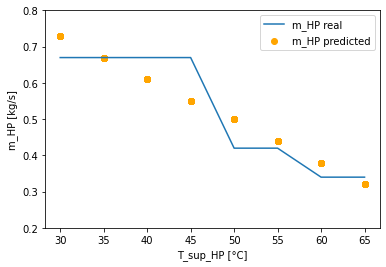

In [6]:
# Plot the real and predicted 1/COP curves
plt.plot(df.T_sup_HP, df.m_HP, label="m_HP real")
plt.scatter(df.T_sup_HP, df.COP_pred, label="m_HP predicted", color='orange')
plt.legend()
plt.xlabel("T_sup_HP [°C]")
plt.ylabel("m_HP [kg/s]")
plt.ylim(0.2,0.8)        

plt.savefig('results/regression_m_HP.jpg', dpi=200)
plt.show()